<a href="https://colab.research.google.com/github/pgurazada/causal_inference/blob/master/02_regression_association.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import graphviz

import numpy as np
import statsmodels.api as sm

from scipy import stats

# Introduction

Regression as a method to estimate causal effects, *when a causal model is specified*. This comes down to choosing proper controls.

$
\hat{y} = 1.12 + 0.93 x_i + 0.5\epsilon_i
$

In [23]:
np.random.seed(42)

In [24]:
N_SAMPLES = 5000

# Define true model parameters
alpha = 1.12
beta = 0.93
epsilon = np.random.randn(N_SAMPLES)

In [25]:
# Generate X
x = np.random.randn(N_SAMPLES)

# Compute Y
y = alpha + beta * x + 0.5 * epsilon

In [26]:
# Statsmodel models require us to add constant
X = sm.add_constant(x)

In [27]:
# Instantiate the model and fit it
model = sm.OLS(y, X)
fitted_model = model.fit()

In [28]:
# Print results summary
print(fitted_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                 1.774e+04
Date:                Mon, 01 Jan 2024   Prob (F-statistic):               0.00
Time:                        04:46:48   Log-Likelihood:                -3610.8
No. Observations:                5000   AIC:                             7226.
Df Residuals:                    4998   BIC:                             7239.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1228      0.007    159.324      0.0

Reversing $x$ and $y$ indicates that regression estimates cannot give guidance on causality.

In [29]:
# Let's remove the constant (now X becomes our target variable)
x_rev = X[:, 1]

# Let's add constant (now Y becomes our predictor)
Y_rev = sm.add_constant(y)

In [30]:
# Instantiate the model and fit it
model_rev = sm.OLS(x_rev, Y_rev)
fitted_model_rev = model_rev.fit()

# Print results summary
print(fitted_model_rev.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                 1.774e+04
Date:                Mon, 01 Jan 2024   Prob (F-statistic):               0.00
Time:                        04:46:58   Log-Likelihood:                -3358.1
No. Observations:                5000   AIC:                             6720.
Df Residuals:                    4998   BIC:                             6733.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9451      0.010    -97.388      0.0

Should we add all the controls? Consider the following structural model.

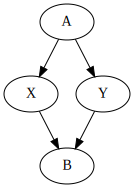

In [33]:
g1 = graphviz.Digraph()
nodes_1 = ['A', 'X', 'B', 'Y']
[g1.node(n) for n in nodes_1]
g1.edges(['AX', 'XB', 'AY', 'YB'])
g1

In [34]:
# Define the sample size
N_SAMPLES = 1000

# Build the graph (note that the coefficients are arbitrarily chosen)
a = np.random.randn(N_SAMPLES)
x = 2 * a + 0.5 * np.random.randn(N_SAMPLES)
y = 2 * a + 0.5 * np.random.randn(N_SAMPLES)
b = 1.5 * x + 0.75 * y

In [36]:
# Define four model variants
variants = [
    [x],
    [x, a],
    [x, b],
    [x, a, b]
]

# Fit models iteratively and store the results
results = []
for variant in variants:
    X = sm.add_constant(np.stack(variant).T)

    # Instantiate the model and fit it
    model = sm.OLS(y, X)
    fitted_model = model.fit()

    results.append((fitted_model.params, fitted_model.pvalues))

    print(f'Params: {fitted_model.params.round(3)}')
    print(f'p-vals: {fitted_model.pvalues.round(3)}')
    print(f'Signif: {fitted_model.pvalues <= .05}\n')

Params: [0.005 0.941]
p-vals: [0.822 0.   ]
Signif: [False  True]

Params: [0.005 0.013 1.997]
p-vals: [0.73  0.679 0.   ]
Signif: [False False  True]

Params: [-0.    -2.     1.333]
p-vals: [0.004 0.    0.   ]
Signif: [ True  True  True]

Params: [ 0.    -2.     0.     1.333]
p-vals: [0.    0.    0.416 0.   ]
Signif: [ True  True False  True]



What if the relationship is non-linear? Will linear regression work?

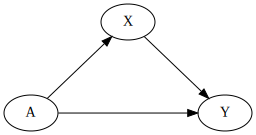

In [38]:
g_2 = graphviz.Digraph(
    graph_attr={
        'rankdir':'LR',
        'ranksep': '.6',
        'nodesep': '1.5'
    }
)

# Add nodes
nodes_2 = ['A', 'X', 'Y']
[g_2.node(n) for n in nodes_2]

g_2.edges(['AY', 'AX', 'XY'])
g_2

In [39]:
# Define the sample size
N_SAMPLES = 1000

# Define the SCM
a = np.random.randn(N_SAMPLES)
x = 2 * a + .7 * np.random.randn(N_SAMPLES)
y = 2 * a + 3 * x + .75 * x**2

In [40]:
# Statsmodel models require us to add constant
X = sm.add_constant(np.stack([x, x**2, a]).T)

# Instantiate the model and fit it
model = sm.OLS(y, X)
fitted_model = model.fit()

# Print results summary
print(fitted_model.summary(xname=['const', 'x', 'x^2', 'a']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.656e+32
Date:                Mon, 01 Jan 2024   Prob (F-statistic):               0.00
Time:                        05:10:30   Log-Likelihood:                 31256.
No. Observations:                1000   AIC:                        -6.250e+04
Df Residuals:                     996   BIC:                        -6.248e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.166e-15   2.46e-16     -4.730      0.0

Add all possible confounders as controls.

# Good and bad controls

## Good control scenarios for $Z$

**Scenario 1: Z is a good control.**

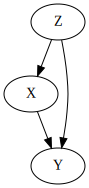

In [41]:
g = graphviz.Digraph()

# Add nodes
nodes = ['Z', 'X', 'Y']
[g.node(n) for n in nodes]

g.edges(['ZY', 'ZX', 'XY'])
g

In [48]:
N_SAMPLES = 1000

z = np.random.randn(N_SAMPLES)
x = z + np.random.randn(N_SAMPLES)
y = x + z + np.random.randn(N_SAMPLES)

X1 = sm.add_constant(np.stack([x]).T)
X2 = sm.add_constant(np.stack([x, z]).T)

Unadjusted estimate

In [53]:
model = sm.OLS(y, X1)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     3079.
Date:                Mon, 01 Jan 2024   Prob (F-statistic):          2.97e-307
Time:                        06:22:00   Log-Likelihood:                -1602.6
No. Observations:                1000   AIC:                             3209.
Df Residuals:                     998   BIC:                             3219.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0391      0.038      1.028      0.3

Adjusted estimate.

In [54]:
model = sm.OLS(y, X2)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x', 'z']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     2662.
Date:                Mon, 01 Jan 2024   Prob (F-statistic):               0.00
Time:                        06:22:19   Log-Likelihood:                -1382.7
No. Observations:                1000   AIC:                             2771.
Df Residuals:                     997   BIC:                             2786.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0116      0.031     -0.380      0.7

**Scenario 2: Z is a good control.**

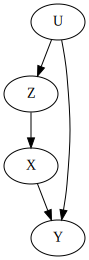

In [55]:
g = graphviz.Digraph()

# Add nodes
nodes = ['U', 'Z', 'X', 'Y']
[g.node(n) for n in nodes]

g.edges(['UZ', 'UY', 'ZX', 'XY'])
g

In [56]:
N_SAMPLES = 1000

u = np.random.randn(N_SAMPLES)
z = u + np.random.randn(N_SAMPLES)
x = z + np.random.randn(N_SAMPLES)
y = x + u + np.random.randn(N_SAMPLES)

X1 = sm.add_constant(np.stack([x]).T)
X2 = sm.add_constant(np.stack([x, z]).T)

Unadjusted estimate

In [57]:
model = sm.OLS(y, X1)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     3333.
Date:                Mon, 01 Jan 2024   Prob (F-statistic):          2.21e-320
Time:                        06:24:56   Log-Likelihood:                -1639.0
No. Observations:                1000   AIC:                             3282.
Df Residuals:                     998   BIC:                             3292.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0533      0.039     -1.351      0.1

Adjusted estimate.

In [58]:
model = sm.OLS(y, X2)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x', 'z']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     1921.
Date:                Mon, 01 Jan 2024   Prob (F-statistic):               0.00
Time:                        06:25:01   Log-Likelihood:                -1583.1
No. Observations:                1000   AIC:                             3172.
Df Residuals:                     997   BIC:                             3187.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0365      0.037     -0.976      0.3

**Scenario 3: Z is a good control.**

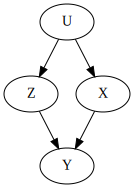

In [59]:
g = graphviz.Digraph()

# Add nodes
nodes = ['U', 'Z', 'X', 'Y']
[g.node(n) for n in nodes]

g.edges(['UZ', 'UX', 'ZY', 'XY'])
g

In [60]:
N_SAMPLES = 1000

u = np.random.randn(N_SAMPLES)
z = u + np.random.randn(N_SAMPLES)
x = u + np.random.randn(N_SAMPLES)
y = x + z + np.random.randn(N_SAMPLES)

X1 = sm.add_constant(np.stack([x]).T)
X2 = sm.add_constant(np.stack([x, z]).T)

Unadjusted estimate

In [61]:
model = sm.OLS(y, X1)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     1671.
Date:                Mon, 01 Jan 2024   Prob (F-statistic):          2.10e-215
Time:                        06:26:56   Log-Likelihood:                -1902.3
No. Observations:                1000   AIC:                             3809.
Df Residuals:                     998   BIC:                             3819.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0716      0.051     -1.394      0.1

Adjusted estimate.

In [62]:
model = sm.OLS(y, X2)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x', 'z']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     3065.
Date:                Mon, 01 Jan 2024   Prob (F-statistic):               0.00
Time:                        06:27:04   Log-Likelihood:                -1410.7
No. Observations:                1000   AIC:                             2827.
Df Residuals:                     997   BIC:                             2842.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0196      0.031     -0.624      0.5

**Scenario 4: Z is a good control.**

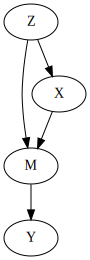

In [63]:
g = graphviz.Digraph()

# Add nodes
nodes = ['M', 'Z', 'X', 'Y']
[g.node(n) for n in nodes]

g.edges(['ZX', 'ZM', 'XM', 'MY'])
g

In [64]:
N_SAMPLES = 1000

z = np.random.randn(N_SAMPLES)
x = z + np.random.randn(N_SAMPLES)
m = x + z + np.random.randn(N_SAMPLES)
y = m + np.random.randn(N_SAMPLES)

X1 = sm.add_constant(np.stack([x]).T)
X2 = sm.add_constant(np.stack([x, z]).T)

Unadjusted estimate

In [65]:
model = sm.OLS(y, X1)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     1917.
Date:                Mon, 01 Jan 2024   Prob (F-statistic):          1.69e-234
Time:                        06:29:09   Log-Likelihood:                -1893.1
No. Observations:                1000   AIC:                             3790.
Df Residuals:                     998   BIC:                             3800.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1429      0.051     -2.809      0.0

Adjusted estimate.

In [66]:
model = sm.OLS(y, X2)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x', 'z']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     1352.
Date:                Mon, 01 Jan 2024   Prob (F-statistic):          1.11e-284
Time:                        06:29:12   Log-Likelihood:                -1773.2
No. Observations:                1000   AIC:                             3552.
Df Residuals:                     997   BIC:                             3567.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1023      0.045     -2.263      0.0

**Scenario 5: Z is a good control.**

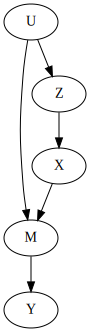

In [67]:
g = graphviz.Digraph()

# Add nodes
nodes = ['U', 'M', 'Z', 'X', 'Y']
[g.node(n) for n in nodes]

g.edges(['UZ', 'UM', 'ZX', 'XM', 'MY'])
g

In [68]:
N_SAMPLES = 1000

u = np.random.randn(N_SAMPLES)
z = u + np.random.randn(N_SAMPLES)
x = z + np.random.randn(N_SAMPLES)
m = x + u + np.random.randn(N_SAMPLES)
y = m + np.random.randn(N_SAMPLES)

X1 = sm.add_constant(np.stack([x]).T)
X2 = sm.add_constant(np.stack([x, z]).T)

Unadjusted estimate

In [69]:
model = sm.OLS(y, X1)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     1814.
Date:                Mon, 01 Jan 2024   Prob (F-statistic):          1.04e-226
Time:                        06:33:40   Log-Likelihood:                -1902.2
No. Observations:                1000   AIC:                             3808.
Df Residuals:                     998   BIC:                             3818.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1078      0.051      2.100      0.0

Adjusted estimate.

In [70]:
model = sm.OLS(y, X2)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x', 'z']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     1008.
Date:                Mon, 01 Jan 2024   Prob (F-statistic):          3.40e-240
Time:                        06:33:42   Log-Likelihood:                -1867.0
No. Observations:                1000   AIC:                             3740.
Df Residuals:                     997   BIC:                             3755.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1245      0.050      2.510      0.0

**Scenario 6: Z is a good control.**

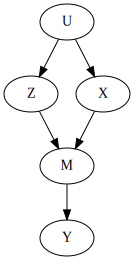

In [71]:
g = graphviz.Digraph()

# Add nodes
nodes = ['U', 'M', 'Z', 'X', 'Y']
[g.node(n) for n in nodes]

g.edges(['UZ', 'UX', 'ZM', 'XM', 'MY'])
g

In [72]:
N_SAMPLES = 1000

u = np.random.randn(N_SAMPLES)
z = u + np.random.randn(N_SAMPLES)
x = u + np.random.randn(N_SAMPLES)
m = x + z + np.random.randn(N_SAMPLES)
y = m + np.random.randn(N_SAMPLES)

X1 = sm.add_constant(np.stack([x]).T)
X2 = sm.add_constant(np.stack([x, z]).T)

Unadjusted estimate

In [73]:
model = sm.OLS(y, X1)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     1362.
Date:                Mon, 01 Jan 2024   Prob (F-statistic):          1.02e-188
Time:                        06:34:54   Log-Likelihood:                -2028.5
No. Observations:                1000   AIC:                             4061.
Df Residuals:                     998   BIC:                             4071.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0607      0.058      1.042      0.2

Adjusted estimate.

In [74]:
model = sm.OLS(y, X2)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x', 'z']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     1607.
Date:                Mon, 01 Jan 2024   Prob (F-statistic):          1.16e-312
Time:                        06:34:54   Log-Likelihood:                -1738.4
No. Observations:                1000   AIC:                             3483.
Df Residuals:                     997   BIC:                             3498.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0489      0.044      1.122      0.2

## Neutral Control scenarios for Z

**Scenario 1**

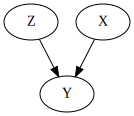

In [76]:
g = graphviz.Digraph()

# Add nodes
nodes = ['Z', 'X', 'Y']
[g.node(n) for n in nodes]

g.edges(['ZY', 'XY'])
g

In [80]:
N_SAMPLES = 1000

z = np.random.randn(N_SAMPLES)
x = np.random.randn(N_SAMPLES)
y = x + 2*z + np.random.randn(N_SAMPLES)

X1 = sm.add_constant(np.stack([x]).T)
X2 = sm.add_constant(np.stack([x, z]).T)

Unadjusted estimate

In [81]:
model = sm.OLS(y, X1)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     213.1
Date:                Mon, 01 Jan 2024   Prob (F-statistic):           6.73e-44
Time:                        07:02:03   Log-Likelihood:                -2226.7
No. Observations:                1000   AIC:                             4457.
Df Residuals:                     998   BIC:                             4467.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1025      0.071      1.444      0.1

Adjusted estimate.

In [82]:
model = sm.OLS(y, X2)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x', 'z']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     2446.
Date:                Mon, 01 Jan 2024   Prob (F-statistic):               0.00
Time:                        07:02:07   Log-Likelihood:                -1435.5
No. Observations:                1000   AIC:                             2877.
Df Residuals:                     997   BIC:                             2892.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0551      0.032      1.711      0.0

**Scenario 2**

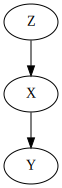

In [83]:
g = graphviz.Digraph()

# Add nodes
nodes = ['Z', 'X', 'Y']
[g.node(n) for n in nodes]

g.edges(['ZX', 'XY'])
g

In [84]:
N_SAMPLES = 1000

z = np.random.randn(N_SAMPLES)
x = 2*z + np.random.randn(N_SAMPLES)
y = x + 2*np.random.randn(N_SAMPLES)

X1 = sm.add_constant(np.stack([x]).T)
X2 = sm.add_constant(np.stack([x, z]).T)

Unadjusted estimate

In [85]:
model = sm.OLS(y, X1)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     1347.
Date:                Mon, 01 Jan 2024   Prob (F-statistic):          2.41e-187
Time:                        07:03:08   Log-Likelihood:                -2107.2
No. Observations:                1000   AIC:                             4218.
Df Residuals:                     998   BIC:                             4228.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0489      0.063      0.774      0.4

Adjusted estimate.

In [86]:
model = sm.OLS(y, X2)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x', 'z']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     672.9
Date:                Mon, 01 Jan 2024   Prob (F-statistic):          1.11e-185
Time:                        07:03:12   Log-Likelihood:                -2107.2
No. Observations:                1000   AIC:                             4220.
Df Residuals:                     997   BIC:                             4235.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0489      0.063      0.774      0.4

**Scenario 3**

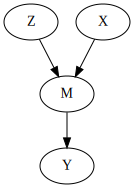

In [88]:
g = graphviz.Digraph()

# Add nodes
nodes = ['M', 'Z', 'X', 'Y']
[g.node(n) for n in nodes]

g.edges(['XM', 'ZM', 'MY'])
g

In [89]:
N_SAMPLES = 1000

z = np.random.randn(N_SAMPLES)
x = np.random.randn(N_SAMPLES)
m = 2*z + np.random.randn(N_SAMPLES)
y = x + 2*m + np.random.randn(N_SAMPLES)

X1 = sm.add_constant(np.stack([x]).T)
X2 = sm.add_constant(np.stack([x, z]).T)

Unadjusted estimate

In [90]:
model = sm.OLS(y, X1)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     63.23
Date:                Mon, 01 Jan 2024   Prob (F-statistic):           4.95e-15
Time:                        07:05:52   Log-Likelihood:                -2939.0
No. Observations:                1000   AIC:                             5882.
Df Residuals:                     998   BIC:                             5892.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0096      0.145      0.066      0.9

Adjusted estimate.

In [91]:
model = sm.OLS(y, X2)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x', 'z']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     1734.
Date:                Mon, 01 Jan 2024   Prob (F-statistic):               0.00
Time:                        07:05:58   Log-Likelihood:                -2220.0
No. Observations:                1000   AIC:                             4446.
Df Residuals:                     997   BIC:                             4461.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0699      0.071      0.990      0.3

**Scenario 4**

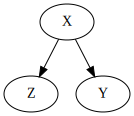

In [92]:
g = graphviz.Digraph()

# Add nodes
nodes = ['Z', 'X', 'Y']
[g.node(n) for n in nodes]

g.edges(['XY', 'XZ'])
g

In [93]:
N_SAMPLES = 1000

x = np.random.randn(N_SAMPLES)
z = 2*x + np.random.randn(N_SAMPLES)
y = x + 2*np.random.randn(N_SAMPLES)

X1 = sm.add_constant(np.stack([x]).T)
X2 = sm.add_constant(np.stack([x, z]).T)

Unadjusted estimate

In [94]:
model = sm.OLS(y, X1)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     302.7
Date:                Mon, 01 Jan 2024   Prob (F-statistic):           2.04e-59
Time:                        07:07:18   Log-Likelihood:                -2110.6
No. Observations:                1000   AIC:                             4225.
Df Residuals:                     998   BIC:                             4235.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0703      0.063      1.112      0.2

Adjusted estimate.

In [95]:
model = sm.OLS(y, X2)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x', 'z']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     151.5
Date:                Mon, 01 Jan 2024   Prob (F-statistic):           3.57e-58
Time:                        07:07:22   Log-Likelihood:                -2110.4
No. Observations:                1000   AIC:                             4227.
Df Residuals:                     997   BIC:                             4242.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0710      0.063      1.122      0.2

**Scenario 5**

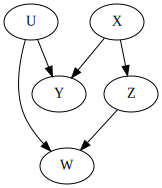

In [96]:
g = graphviz.Digraph()

# Add nodes
nodes = ['W', 'U', 'Z', 'X', 'Y']
[g.node(n) for n in nodes]

g.edges(['XY', 'XZ', 'ZW', 'UW', 'UY'])
g

In [97]:
N_SAMPLES = 1000

x = np.random.randn(N_SAMPLES)
u = np.random.randn(N_SAMPLES)
z = x + np.random.randn(N_SAMPLES)
w = z + u + np.random.randn(N_SAMPLES)
y = x - 2*u + np.random.randn(N_SAMPLES)

X1 = sm.add_constant(np.stack([x, w]).T)
X2 = sm.add_constant(np.stack([x, z, w]).T)

Unadjusted estimate

In [99]:
model = sm.OLS(y, X1)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x', 'w']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     309.8
Date:                Mon, 01 Jan 2024   Prob (F-statistic):          2.33e-105
Time:                        07:11:23   Log-Likelihood:                -2057.7
No. Observations:                1000   AIC:                             4121.
Df Residuals:                     997   BIC:                             4136.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0529      0.060     -0.881      0.3

Adjusted estimate.

In [100]:
model = sm.OLS(y, X2)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x', 'z', 'w']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     316.2
Date:                Mon, 01 Jan 2024   Prob (F-statistic):          3.44e-144
Time:                        07:11:39   Log-Likelihood:                -1964.8
No. Observations:                1000   AIC:                             3938.
Df Residuals:                     996   BIC:                             3957.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0367      0.055     -0.670      0.5

## Bad control scenarios for $Z$

**Scenario 1: M-Bias**

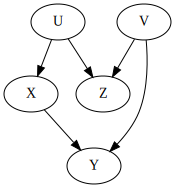

In [103]:
g = graphviz.Digraph()

# Add nodes
nodes = ['U', 'V', 'Z', 'X', 'Y']
[g.node(n) for n in nodes]

g.edges(['XY', 'UX', 'UZ', 'VZ', 'VY'])
g

In [104]:
N_SAMPLES = 1000

u = np.random.randn(N_SAMPLES)
v = np.random.randn(N_SAMPLES)
z = x + np.random.randn(N_SAMPLES)
z = u + v + np.random.randn(N_SAMPLES)
x = u + np.random.randn(N_SAMPLES)
y = x - 4*v + np.random.randn(N_SAMPLES)

X1 = sm.add_constant(np.stack([x]).T)
X2 = sm.add_constant(np.stack([x, z]).T)

Unadjusted estimate

In [107]:
model = sm.OLS(y, X1)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     110.4
Date:                Mon, 01 Jan 2024   Prob (F-statistic):           1.48e-24
Time:                        07:16:13   Log-Likelihood:                -2810.9
No. Observations:                1000   AIC:                             5626.
Df Residuals:                     998   BIC:                             5636.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2087      0.127      1.639      0.1

Adjusted estimate.

In [108]:
model = sm.OLS(y, X2)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x', 'z']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     384.1
Date:                Mon, 01 Jan 2024   Prob (F-statistic):          2.14e-124
Time:                        07:16:19   Log-Likelihood:                -2577.7
No. Observations:                1000   AIC:                             5161.
Df Residuals:                     997   BIC:                             5176.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0969      0.101      0.959      0.3

**Scenario 2: Bias amplification**

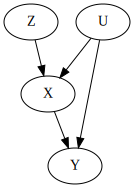

In [109]:
g = graphviz.Digraph()

# Add nodes
nodes = ['U', 'Z', 'X', 'Y']
[g.node(n) for n in nodes]

g.edges(['XY', 'UX', 'UY', 'ZX'])
g

In [110]:
N_SAMPLES = 1000

u = np.random.randn(N_SAMPLES)
z = np.random.randn(N_SAMPLES)
x = 2*z + u + np.random.randn(N_SAMPLES)
y = x + 2*u + np.random.randn(N_SAMPLES)

X1 = sm.add_constant(np.stack([x]).T)
X2 = sm.add_constant(np.stack([x, z]).T)

Unadjusted estimate

In [111]:
model = sm.OLS(y, X1)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     2347.
Date:                Mon, 01 Jan 2024   Prob (F-statistic):          2.29e-264
Time:                        07:18:41   Log-Likelihood:                -2173.7
No. Observations:                1000   AIC:                             4351.
Df Residuals:                     998   BIC:                             4361.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0697      0.067      1.034      0.3

Adjusted estimate.

In [112]:
model = sm.OLS(y, X2)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x', 'z']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     1988.
Date:                Mon, 01 Jan 2024   Prob (F-statistic):               0.00
Time:                        07:18:45   Log-Likelihood:                -1974.9
No. Observations:                1000   AIC:                             3956.
Df Residuals:                     997   BIC:                             3970.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0524      0.055      0.948      0.3

**Scenario 3: Overcontrol bias**

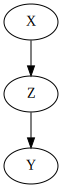

In [114]:
g = graphviz.Digraph()

# Add nodes
nodes = ['Z', 'X', 'Y']
[g.node(n) for n in nodes]

g.edges(['XZ', 'ZY'])
g

In [115]:
N_SAMPLES = 1000

x = np.random.randn(N_SAMPLES)
z = x + np.random.randn(N_SAMPLES)
y = z + np.random.randn(N_SAMPLES)

X1 = sm.add_constant(np.stack([x]).T)
X2 = sm.add_constant(np.stack([x, z]).T)

Unadjusted estimate

In [116]:
model = sm.OLS(y, X1)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     503.9
Date:                Mon, 01 Jan 2024   Prob (F-statistic):           1.13e-90
Time:                        07:20:34   Log-Likelihood:                -1758.4
No. Observations:                1000   AIC:                             3521.
Df Residuals:                     998   BIC:                             3531.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0580      0.045      1.302      0.1

Adjusted estimate.

In [117]:
model = sm.OLS(y, X2)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x', 'z']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     1027.
Date:                Mon, 01 Jan 2024   Prob (F-statistic):          7.18e-243
Time:                        07:20:38   Log-Likelihood:                -1403.6
No. Observations:                1000   AIC:                             2813.
Df Residuals:                     997   BIC:                             2828.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0043      0.031     -0.136      0.8

**Scenario 4: Overcontrol bias**

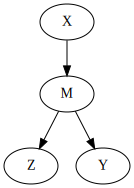

In [ ]:
g = graphviz.Digraph()

# Add nodes
nodes = ['M', 'Z', 'X', 'Y']
[g.node(n) for n in nodes]

g.edges(['XM', 'MZ', 'MY'])
g

In [ ]:
N_SAMPLES = 1000

x = np.random.randn(N_SAMPLES)
m = x + np.random.randn(N_SAMPLES)
z = m + np.random.randn(N_SAMPLES)
y = m + np.random.randn(N_SAMPLES)

X1 = sm.add_constant(np.stack([x]).T)
X2 = sm.add_constant(np.stack([x, z]).T)

Unadjusted estimate

In [ ]:
model = sm.OLS(y, X1)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     531.2
Date:                Mon, 01 Jan 2024   Prob (F-statistic):           1.43e-94
Time:                        07:22:21   Log-Likelihood:                -1785.3
No. Observations:                1000   AIC:                             3575.
Df Residuals:                     998   BIC:                             3584.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0364      0.046      0.797      0.4

Adjusted estimate.

In [ ]:
model = sm.OLS(y, X2)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x', 'z']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     535.4
Date:                Mon, 01 Jan 2024   Prob (F-statistic):          1.15e-158
Time:                        07:22:25   Log-Likelihood:                -1633.9
No. Observations:                1000   AIC:                             3274.
Df Residuals:                     997   BIC:                             3289.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0071      0.039      0.182      0.8

**Scenario 5: Selection bias**

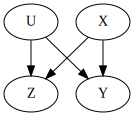

In [122]:
g = graphviz.Digraph()

# Add nodes
nodes = ['U', 'Z', 'X', 'Y']
[g.node(n) for n in nodes]

g.edges(['XY', 'XZ', 'UZ', 'UY'])
g

In [123]:
N_SAMPLES = 1000

x = np.random.randn(N_SAMPLES)
u = np.random.randn(N_SAMPLES)
z = x + u + np.random.randn(N_SAMPLES)
y = x + 2*u + np.random.randn(N_SAMPLES)

X1 = sm.add_constant(np.stack([x]).T)
X2 = sm.add_constant(np.stack([x, z]).T)

Unadjusted estimate

In [124]:
model = sm.OLS(y, X1)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     225.4
Date:                Mon, 01 Jan 2024   Prob (F-statistic):           4.25e-46
Time:                        07:24:35   Log-Likelihood:                -2219.0
No. Observations:                1000   AIC:                             4442.
Df Residuals:                     998   BIC:                             4452.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0601      0.070     -0.853      0.3

Adjusted estimate.

In [125]:
model = sm.OLS(y, X2)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x', 'z']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     565.4
Date:                Mon, 01 Jan 2024   Prob (F-statistic):          7.36e-165
Time:                        07:24:37   Log-Likelihood:                -1941.8
No. Observations:                1000   AIC:                             3890.
Df Residuals:                     997   BIC:                             3904.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0309      0.053     -0.578      0.5

**Scenario 6: Selection bias**

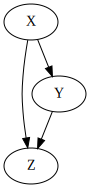

In [126]:
g = graphviz.Digraph()

# Add nodes
nodes = ['Z', 'X', 'Y']
[g.node(n) for n in nodes]

g.edges(['XY', 'XZ', 'YZ'])
g

In [127]:
N_SAMPLES = 1000

x = np.random.randn(N_SAMPLES)
y = x + np.random.randn(N_SAMPLES)
z = x + y + np.random.randn(N_SAMPLES)

X1 = sm.add_constant(np.stack([x]).T)
X2 = sm.add_constant(np.stack([x, z]).T)

Unadjusted estimate

In [128]:
model = sm.OLS(y, X1)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     964.6
Date:                Mon, 01 Jan 2024   Prob (F-statistic):          9.99e-149
Time:                        07:28:15   Log-Likelihood:                -1422.9
No. Observations:                1000   AIC:                             2850.
Df Residuals:                     998   BIC:                             2860.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0291      0.032      0.915      0.3

Adjusted estimate.

In [129]:
model = sm.OLS(y, X2)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x', 'z']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     1485.
Date:                Mon, 01 Jan 2024   Prob (F-statistic):          1.17e-299
Time:                        07:28:16   Log-Likelihood:                -1070.7
No. Observations:                1000   AIC:                             2147.
Df Residuals:                     997   BIC:                             2162.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0218      0.022      0.975      0.3

**Scenario 7: Case-control bias**

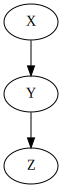

In [130]:
g = graphviz.Digraph()

# Add nodes
nodes = ['Z', 'X', 'Y']
[g.node(n) for n in nodes]

g.edges(['XY', 'YZ'])
g

In [131]:
N_SAMPLES = 1000

x = np.random.randn(N_SAMPLES)
y = x + np.random.randn(N_SAMPLES)
z = y + np.random.randn(N_SAMPLES)

X1 = sm.add_constant(np.stack([x]).T)
X2 = sm.add_constant(np.stack([x, z]).T)

Unadjusted estimate

In [132]:
model = sm.OLS(y, X1)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     904.7
Date:                Mon, 01 Jan 2024   Prob (F-statistic):          5.29e-142
Time:                        07:29:27   Log-Likelihood:                -1440.5
No. Observations:                1000   AIC:                             2885.
Df Residuals:                     998   BIC:                             2895.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0120      0.032      0.372      0.7

Adjusted estimate.

In [133]:
model = sm.OLS(y, X2)
fitted_model = model.fit()

print(fitted_model.summary(xname=['const', 'x', 'z']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     1332.
Date:                Mon, 01 Jan 2024   Prob (F-statistic):          2.62e-282
Time:                        07:29:29   Log-Likelihood:                -1112.8
No. Observations:                1000   AIC:                             2232.
Df Residuals:                     997   BIC:                             2246.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0219      0.023      0.937      0.3